In [101]:
!pip install lalsuite
!pip install gw-phenom
!pip install gw-wispy
!pip install pugna

In [102]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [103]:
pip install tensorflow-addons

In [104]:
import tensorflow_addons as tfa
print(tfa.__version__)

0.13.0


In [105]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use("ggplot")
# mpl.rcParams.update({"font.size": 16})

import multiprocessing as mp
import functools

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import wispy.lalutils
import wispy.model_utils
import wispy.callbacks
import wispy.resnet

import lalsimulation as lalsim

from sklearn.preprocessing import MinMaxScaler

In [106]:
import pugna.layers
import pugna.activations
import pugna.callbacks

from tensorflow.keras.utils import get_custom_objects
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do 
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [107]:
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [108]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

# network functions

In [109]:
# need a function to create sub-networks
def build_subnetwork(input_tensor, units, activation='relu', n_blocks=1):
    """
    n_blocks >= 1
    """
    assert n_blocks >= 1, f"n_blocks must be >1, got {n_blocks}"

    # tmp = input_tensor
    tmp = tf.keras.layers.Dense(units, activation=activation)(input_tensor)

    x = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
    # x = tfa.layers.GroupNormalization(groups=1)(x)
    # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    for _ in range(n_blocks):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        # x = tfa.layers.GroupNormalization(groups=1)(x)
        # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)

        x = tf.keras.layers.add([x, tmp])
        tmp = x

    # single output here?
    x = tf.keras.layers.Dense(1, activation='linear')(x)

    return x

In [110]:
# constant scale
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(ScaleLayer, self).__init__()
        self.scale = scale
        
    def call(self, inputs):
        return inputs * self.scale
    
    def get_config(self):
        config = super(ScaleLayer, self).get_config()
        config.update({"scale": self.scale})
        return config

In [111]:
# constant shift
class ShiftLayer(tf.keras.layers.Layer):
    def __init__(self, shift, **kwargs):
        super(ShiftLayer, self).__init__()
        self.shift = shift
        
    def call(self, inputs):
        return inputs + self.shift
    
    def get_config(self):
        config = super(ShiftLayer, self).get_config()
        config.update({"shift": self.shift})
        return config

In [112]:
TEST_X = tf.convert_to_tensor([[1.],[2.],[3.]]) 

In [113]:
TEST_X

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [114]:
ShiftLayer(1)(TEST_X)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[2.],
       [3.],
       [4.]], dtype=float32)>

In [115]:
ShiftLayer(-1)(TEST_X)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [2.]], dtype=float32)>

In [116]:
# this version supports variable number of units and blocks for each scale.
# the idea is that maybe smaller scales can cope with smaller networks
def build_model_scale(
    input_shape = 1,
    output_shape = 1,
    units = [128],
    activation = 'relu',
    n_blocks = [2],
    scales = [1]
    ):
    assert len(scales) == len(n_blocks) == len(units), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scaled_input = ScaleLayer(scale)(input_layer)
#         scaled_input = ScaleLayer_Trainable(scale)(input_layer)
#         scaled_input = ScaleLayer_Trainable_v2()(input_layer)
        xs.append(build_subnetwork(scaled_input, units[i], activation, n_blocks[i]))

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [117]:
# this version supports variable number of units and blocks for each scale.
# the idea is that maybe smaller scales can cope with smaller networks
def build_model_shift(
    input_shape = 1,
    output_shape = 1,
    units = [128],
    activation = 'relu',
    n_blocks = [2],
    shifts = [1]
    ):
    assert len(shifts) == len(n_blocks) == len(units), "units, n_blocks, shifts must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, shift in enumerate(shifts):
        shifted_input = ShiftLayer(shift)(input_layer)
        xs.append(build_subnetwork(shifted_input, units[i], activation, n_blocks[i]))

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model 

In [118]:
# this version supports variable number of units and blocks for each scale.
# the idea is that maybe smaller scales can cope with smaller networks
def build_model_shift_and_scale(
    input_shape = 1,
    output_shape = 1,
    units = [128],
    activation = 'relu',
    n_blocks = [2],
    shifts = [1],
    scales = [1]
    ):
    assert len(scales) == len(n_blocks) == len(units), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, shift in enumerate(shifts):
        shifted_input = ShiftLayer(shift)(input_layer)
        for j, scale in enumerate(scales):
            scaled_input = ScaleLayer(scale)(shifted_input)
            xs.append(build_subnetwork(scaled_input, units[j], activation, n_blocks[j]))

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model 

In [119]:
def get_compiled_model(
        model_name,
        input_shape = 1,
        output_shape = 1,
        units = [128],
        n_blocks = [1],
        scales = [1],
        shifts = [1],
        activation = 'relu',
        lr=1e-3,
        loss='mse',
        metrics=None
    ):

    if model_name == "scale":
        model = build_model_scale(
            input_shape=input_shape,
            output_shape=output_shape,
            units=units,
            activation=activation,
            n_blocks=n_blocks,
            scales=scales
            )
    elif model_name == "shift":
        model = build_model_shift(
            input_shape=input_shape,
            output_shape=output_shape,
            units=units,
            activation=activation,
            n_blocks=n_blocks,
            shifts=shifts
            )
    elif model_name == "shift_and_scale":
        print("ASDA")
        model = build_model_shift_and_scale(
            input_shape=input_shape,
            output_shape=output_shape,
            units=units,
            activation=activation,
            n_blocks=n_blocks,
            shifts=shifts,
            scales=scales
            )

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

# data generation

In [120]:
def gen_data(s1x=0.99, q=1, M=100, nproc=1, t_min=-500, validation=False, val_size=100):

    m1, m2 = phenom.m1_m2_M_q(M, q)
    ps = [wispy.lalutils.gen_td_wf_params(m1=m1, m2=m2, S1x=s1x, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6)]

    times = []
    amp = []
    phase = []

    func = functools.partial(wispy.lalutils.gen_td_wf, t_max=60, t_min=t_min)

    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)
#     print(len(returned))
#     print(len(returned[0]))
#     print(returned[0])
    for i in range(len(returned)):
        times.append(returned[i][0])
        amp.append(returned[i][1])
        phase.append(returned[i][2])



    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")
    
    common_times = np.arange(common_tmin, common_tmax, dt_M)
    if validation is True:
        if val_size is None:
            val_size=len(common_times)
        common_times = np.random.uniform(low=common_tmin, high=common_tmax, size=val_size)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")

    n_cases = len(ps)

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)

    return common_times, amps, phases

In [121]:
# these pre-precessing steps are different because we only consider one waveform

def compute_pre_process(ys):
    ys = ys.copy()
    ys_max = np.max(ys)

    return ys_max

def apply_pre_process_forward(ys, y_max):
    ys = ys.copy()
    ys /= y_max

    return ys

def apply_pre_process_reverse(ys, y_max):
    ys = ys.copy()
    ys *= y_max

    return ys

In [122]:
%%time
common_times, amps, phases = gen_data(s1x=0.99, q=3, M=100, nproc=1, t_min=-500)

common_tmin = -499.8983296249211
common_tmax = 59.71037577269179
ntimes = 1120
CPU times: user 35.2 ms, sys: 34.5 ms, total: 69.7 ms
Wall time: 5.05 s


In [123]:
%%time
common_times_val, amps_val, phases_val = gen_data(s1x=0.99, q=3, M=100, nproc=1, t_min=-500, validation=True, val_size=None)

common_tmin = -499.8983296249211
common_tmax = 59.71037577269179
ntimes = 1120
CPU times: user 33.5 ms, sys: 22.5 ms, total: 56 ms
Wall time: 4.95 s


In [124]:
y_max = compute_pre_process(amps)

amps_prime = apply_pre_process_forward(amps, y_max)

# scale times to between -1, 1
times_scaler = MinMaxScaler(feature_range=(-1,1)) # this works better than (0,1)
# times_scaler = MinMaxScaler(feature_range=(0,1))
common_times_scaled = times_scaler.fit_transform(common_times[:, np.newaxis])[:,0]

# X = convert_input_for_ann(common_times, s1x_arr)
# X = convert_input_for_ann(common_times_scaled, s1x_arr)

X = common_times_scaled.copy().reshape(-1,1)
y = amps_prime.ravel().reshape(-1, 1)


amps_val_prime = apply_pre_process_forward(amps_val, y_max)
common_times_scaled_val = times_scaler.transform(common_times_val[:,np.newaxis])[:,0]

X_val = common_times_scaled_val.copy().reshape(-1,1)
y_val = amps_val_prime.ravel().reshape(-1, 1)


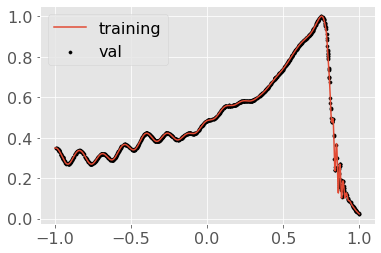

In [125]:
plt.figure()
plt.plot(X, y, label='training')
plt.scatter(X_val, y_val, label='val', s=10, c='k')
plt.legend()
# plt.xlim(0.5, 1)

# fit using shift-network

In [126]:
input_shape = X.shape[1]
output_shape = y.shape[1]

units = [256,256]
n_blocks = [2,2]
shifts = [-1,0]
activation = 's2relu'

lr=1e-3
loss='mse'
# metrics=['mse']
metrics=None

In [127]:
shift={}

shift['model'] = get_compiled_model(
    model_name="shift",
    input_shape=input_shape, output_shape=output_shape, units=units,
    shifts=shifts,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

shift['model'].summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
shift_layer_25 (ShiftLayer)     (None, 1)            0           input_15[0][0]                   
__________________________________________________________________________________________________
shift_layer_26 (ShiftLayer)     (None, 1)            0           input_15[0][0]                   
__________________________________________________________________________________________________
dense_372 (Dense)               (None, 256)          512         shift_layer_25[0][0]             
___________________________________________________________________________________________

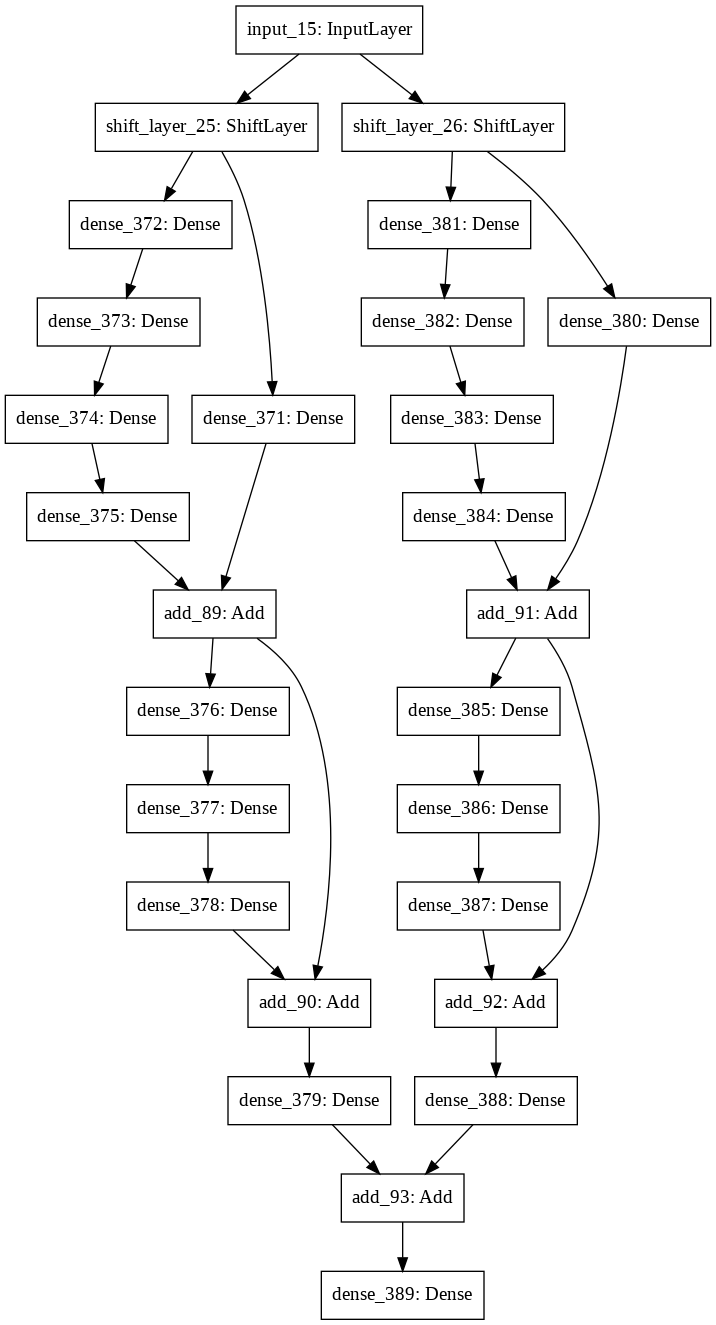

In [128]:
tf.keras.utils.plot_model(shift['model']) 

In [129]:
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=200, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
# callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
callbacks = [reduce_lr, pugna.callbacks.PrintDot()]
# callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 1120


In [130]:
starttime = datetime.datetime.now()

shift['history'] = shift['model'].fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=None
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

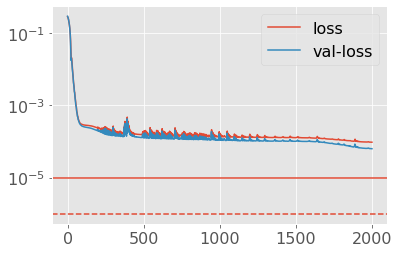

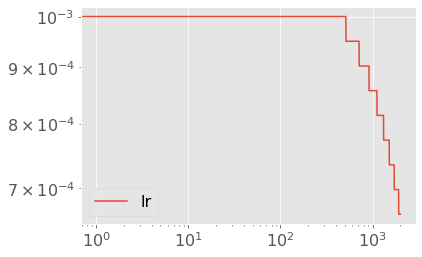

In [131]:
plt.figure()
plt.plot(shift['history'].history['loss'], label='loss')
plt.plot(shift['history'].history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

if 'lr' in shift['history'].history.keys():
    plt.figure()
    plt.plot(shift['history'].history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

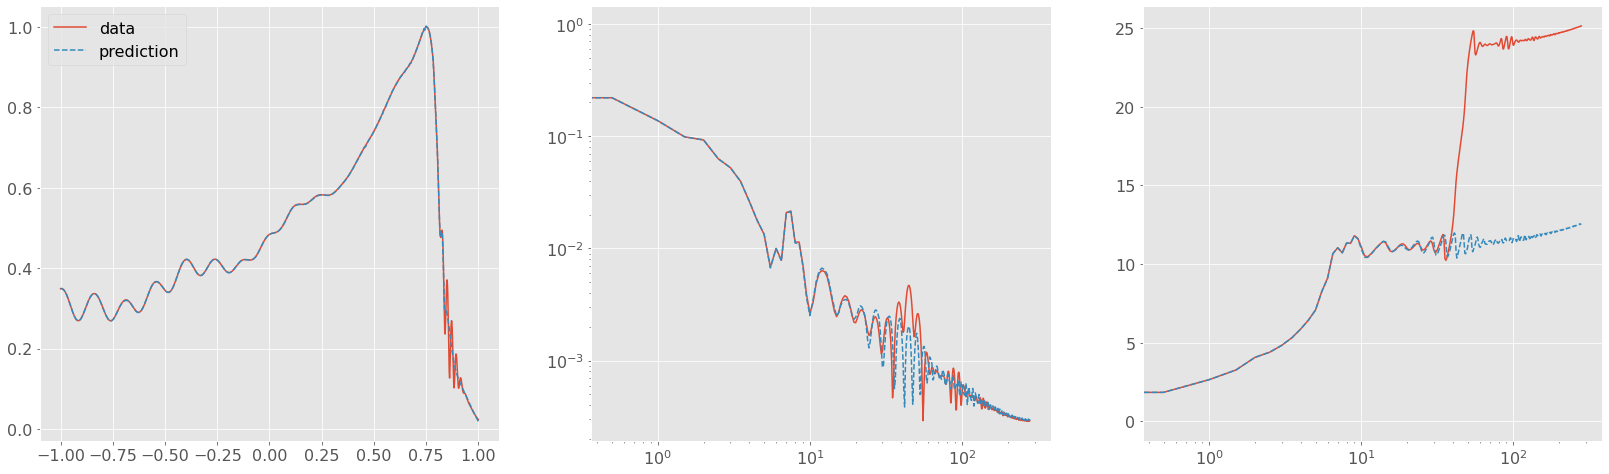

In [132]:
yhat = shift['model'].predict(common_times_scaled).T
xf, yf = compute_fft(common_times_scaled, amps_prime[0])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(0.75, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

# fit using scale network

In [133]:
input_shape = X.shape[1]
output_shape = y.shape[1]

units = [256,256]
n_blocks = [2,2]
scales = [1, 10]
activation = 's2relu'

lr=1e-3
loss='mse'
# metrics=['mse']
metrics=None

In [134]:
scale={}

scale['model'] = get_compiled_model(
    model_name="scale",
    input_shape=input_shape, output_shape=output_shape, units=units,
    scales=scales,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

scale['model'].summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_40 (ScaleLayer)     (None, 1)            0           input_16[0][0]                   
__________________________________________________________________________________________________
scale_layer_41 (ScaleLayer)     (None, 1)            0           input_16[0][0]                   
__________________________________________________________________________________________________
dense_391 (Dense)               (None, 256)          512         scale_layer_40[0][0]             
___________________________________________________________________________________________

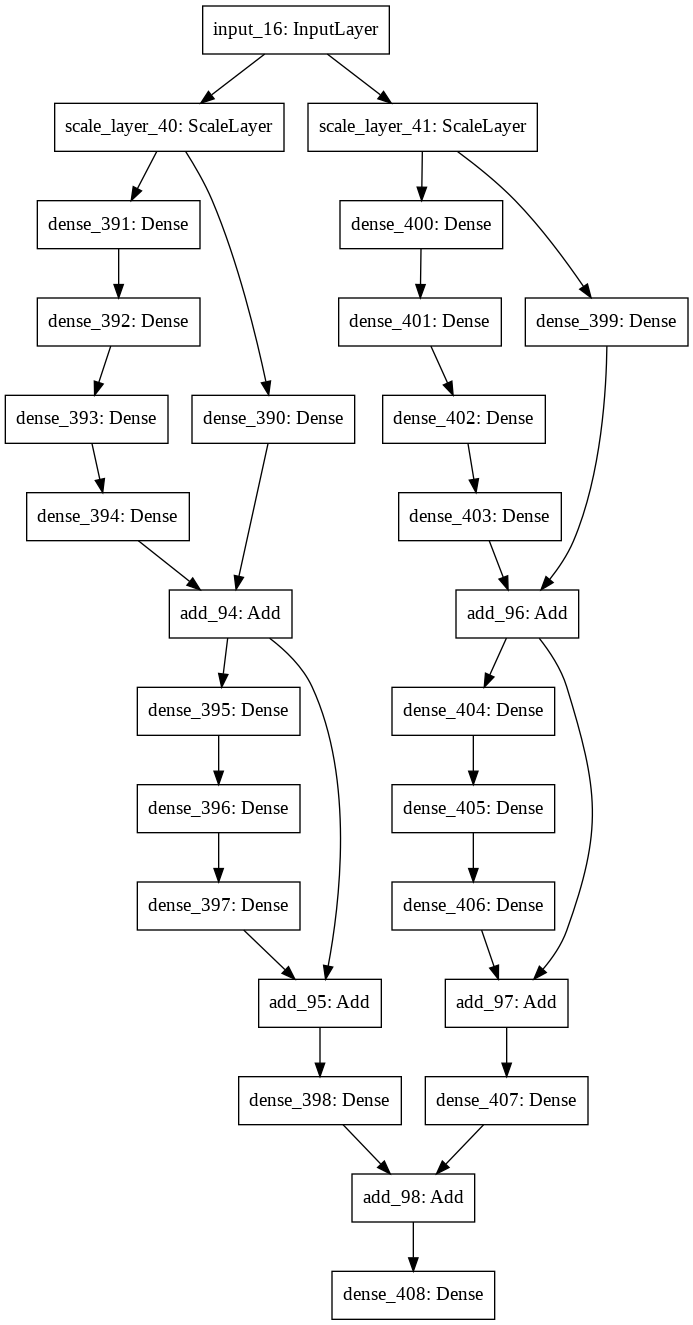

In [135]:
tf.keras.utils.plot_model(scale['model']) 

In [136]:
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=200, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
# callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
callbacks = [reduce_lr, pugna.callbacks.PrintDot()]
# callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 1120


In [137]:
starttime = datetime.datetime.now()

scale['history'] = scale['model'].fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=None
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

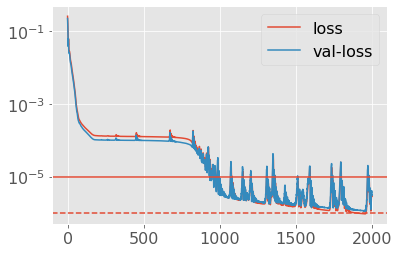

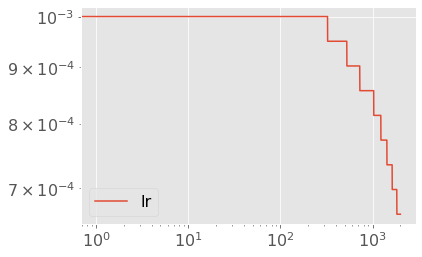

In [138]:
plt.figure()
plt.plot(scale['history'].history['loss'], label='loss')
plt.plot(scale['history'].history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

if 'lr' in scale['history'].history.keys():
    plt.figure()
    plt.plot(scale['history'].history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

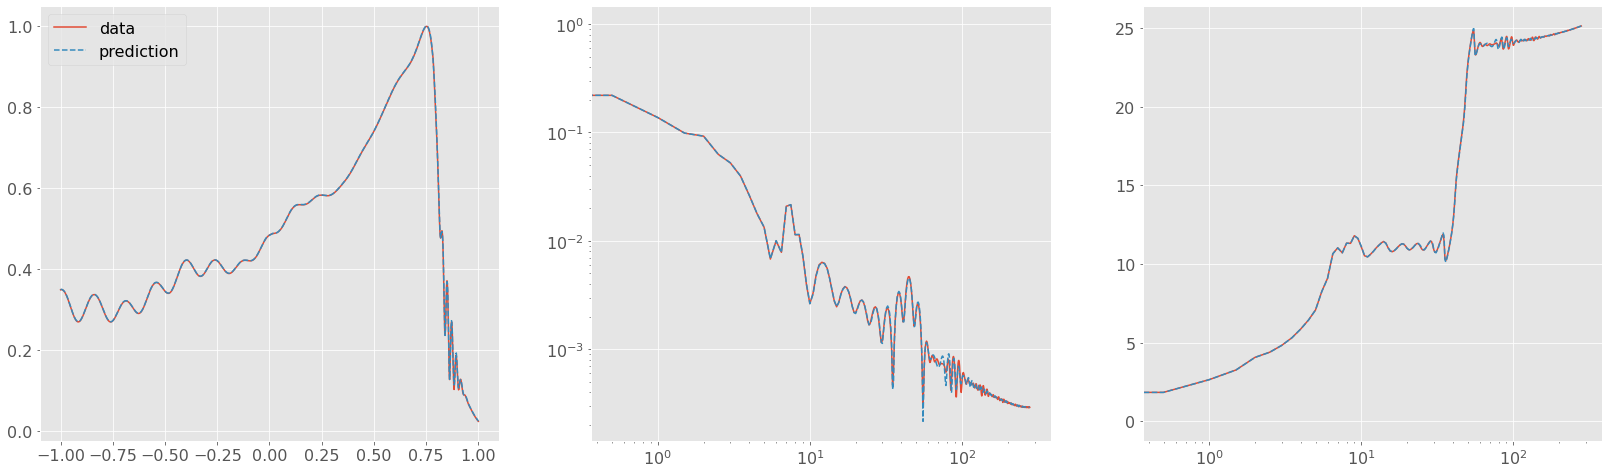

In [139]:
yhat = scale['model'].predict(common_times_scaled).T
xf, yf = compute_fft(common_times_scaled, amps_prime[0])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(0.75, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

# fit using shift and scale

In [140]:
input_shape = X.shape[1]
output_shape = y.shape[1]

units = [180,180]
n_blocks = [2,2]
shifts = [-1,0]
scales = [1,10]
activation = 's2relu'

lr=1e-3
loss='mse'
# metrics=['mse']
metrics=None

In [141]:
shift_and_scale={}

shift_and_scale['model'] = get_compiled_model(
    model_name="shift_and_scale",
    input_shape=input_shape, output_shape=output_shape, units=units,
    shifts=shifts,
    scales=scales,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

shift_and_scale['model'].summary()

ASDA
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
shift_layer_27 (ShiftLayer)     (None, 1)            0           input_17[0][0]                   
__________________________________________________________________________________________________
shift_layer_28 (ShiftLayer)     (None, 1)            0           input_17[0][0]                   
__________________________________________________________________________________________________
scale_layer_42 (ScaleLayer)     (None, 1)            0           shift_layer_27[0][0]             
______________________________________________________________________________________

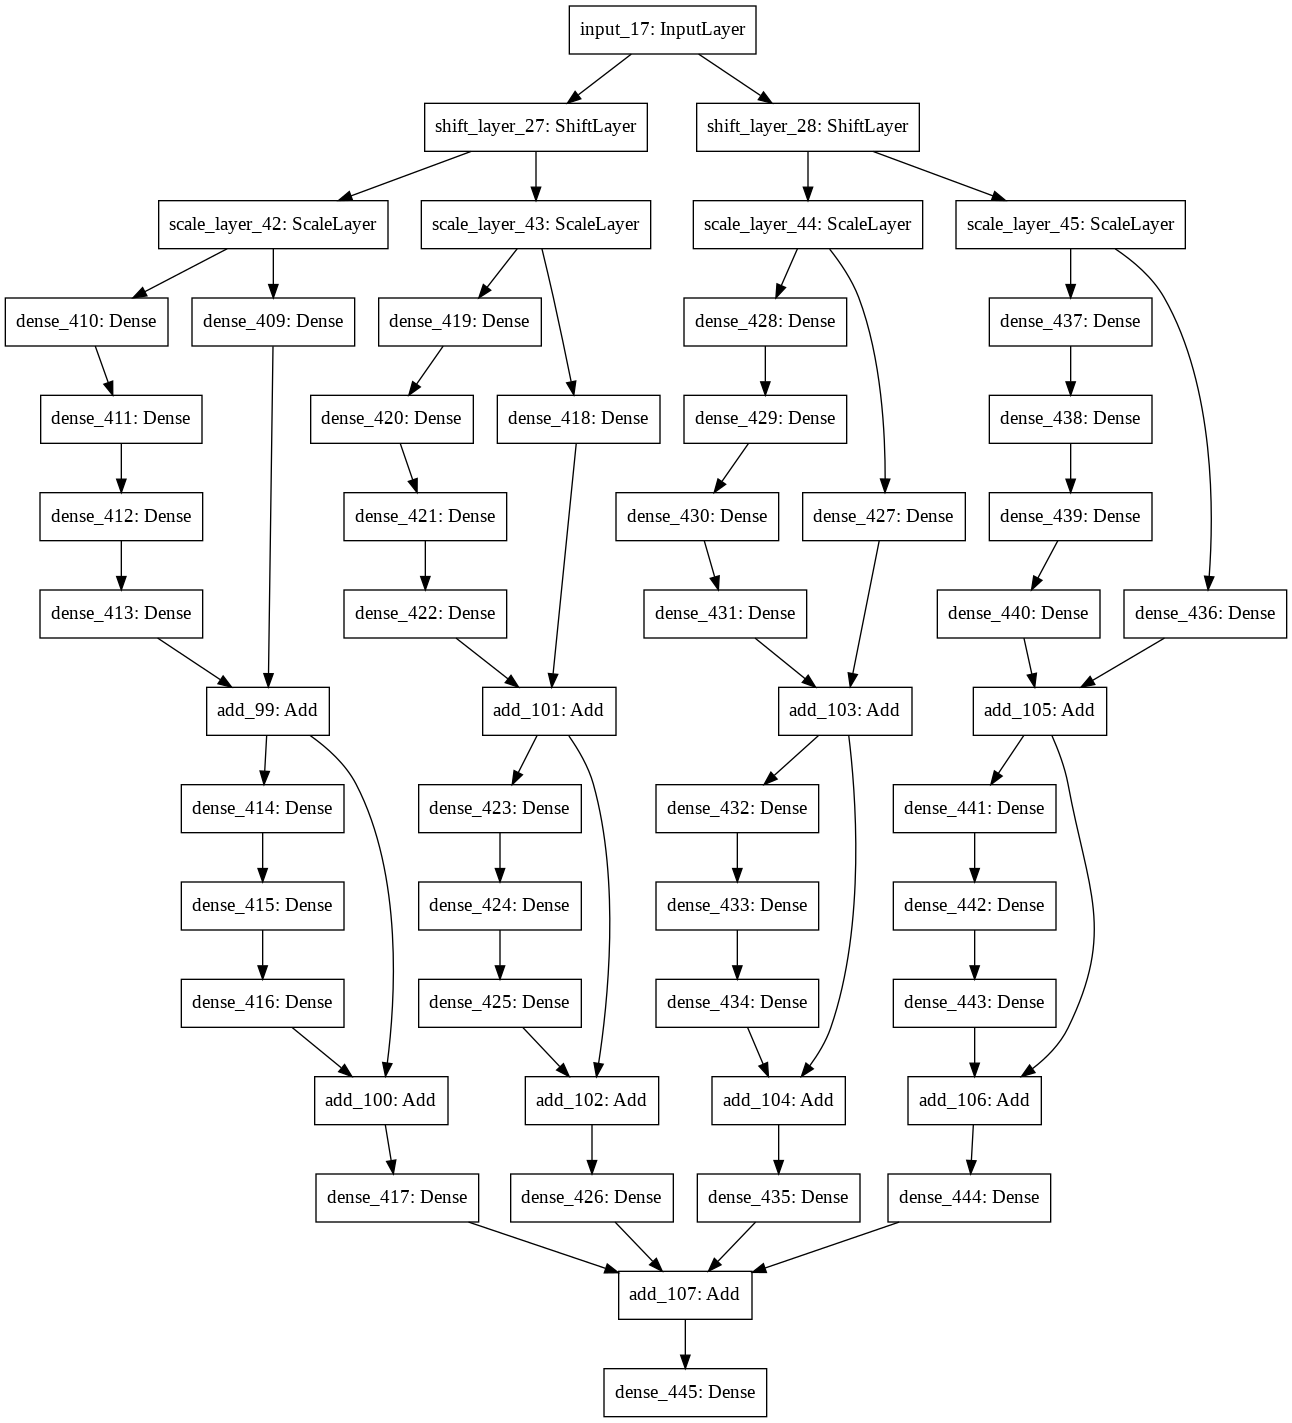

In [142]:
tf.keras.utils.plot_model(shift_and_scale['model']) 

In [143]:
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=200, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
# callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
callbacks = [reduce_lr, pugna.callbacks.PrintDot()]
# callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 1120


In [144]:
starttime = datetime.datetime.now()

shift_and_scale['history'] = shift_and_scale['model'].fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=None
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

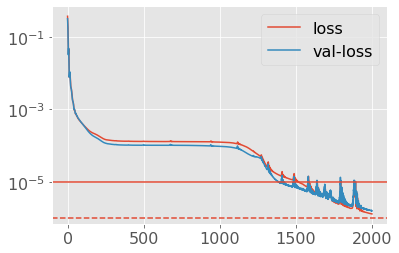

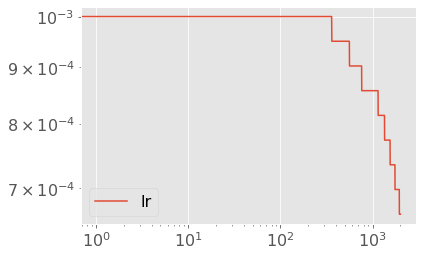

In [145]:
plt.figure()
plt.plot(shift_and_scale['history'].history['loss'], label='loss')
plt.plot(shift_and_scale['history'].history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

if 'lr' in shift_and_scale['history'].history.keys():
    plt.figure()
    plt.plot(shift_and_scale['history'].history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

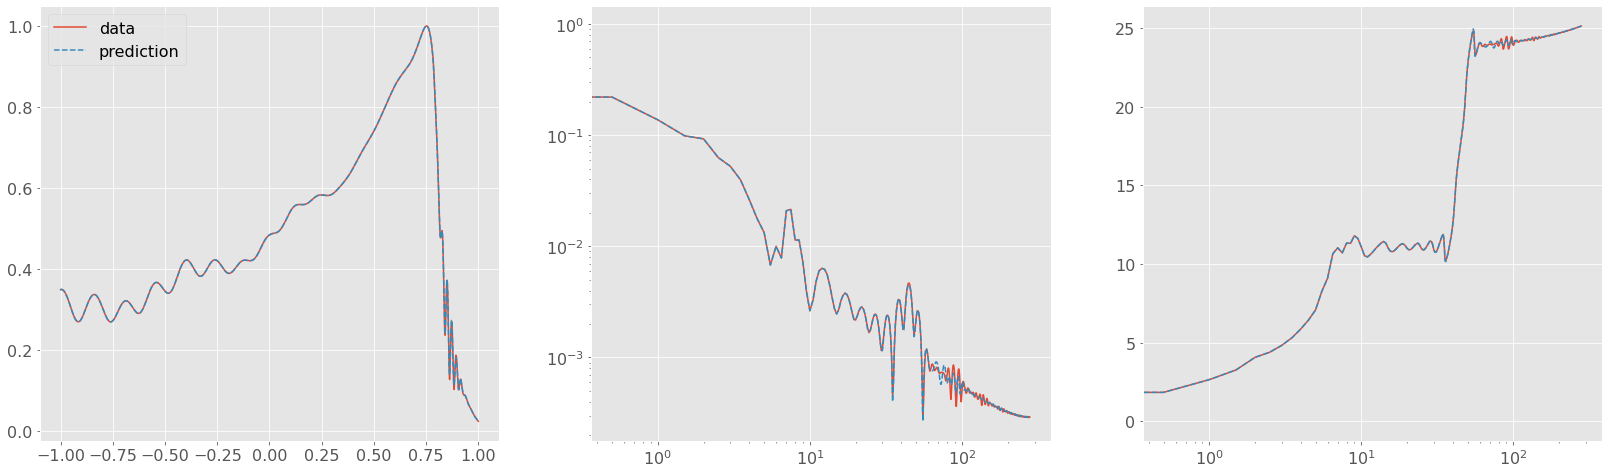

In [146]:
yhat = shift_and_scale['model'].predict(common_times_scaled).T
xf, yf = compute_fft(common_times_scaled, amps_prime[0])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(0.75, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

# comparisons

In [147]:
print("shift\n")
shift['model'].summary()
print("scale\n")
scale['model'].summary()
print("shift_and_scale\n")
shift_and_scale['model'].summary()

shift

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
shift_layer_25 (ShiftLayer)     (None, 1)            0           input_15[0][0]                   
__________________________________________________________________________________________________
shift_layer_26 (ShiftLayer)     (None, 1)            0           input_15[0][0]                   
__________________________________________________________________________________________________
dense_372 (Dense)               (None, 256)          512         shift_layer_25[0][0]             
____________________________________________________________________________________

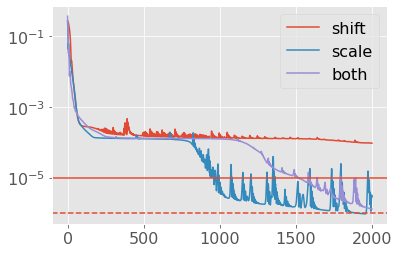

In [148]:
plt.figure()

plt.plot(shift['history'].history['loss'], label='shift')
# plt.plot(shift['history'].history['val_loss'], ls='--')


plt.plot(scale['history'].history['loss'], label='scale')
# plt.plot(scale['history'].history['val_loss'], ls='--')

plt.plot(shift_and_scale['history'].history['loss'], label='both')
# plt.plot(shift_and_scale['history'].history['val_loss'], ls='--')




plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

# if 'lr' in shift_and_scale['history'].history.keys():
#     plt.figure()
#     plt.plot(shift_and_scale['history'].history['lr'], label='lr')
#     plt.legend()
#     plt.yscale('log')
#     plt.xscale('log')

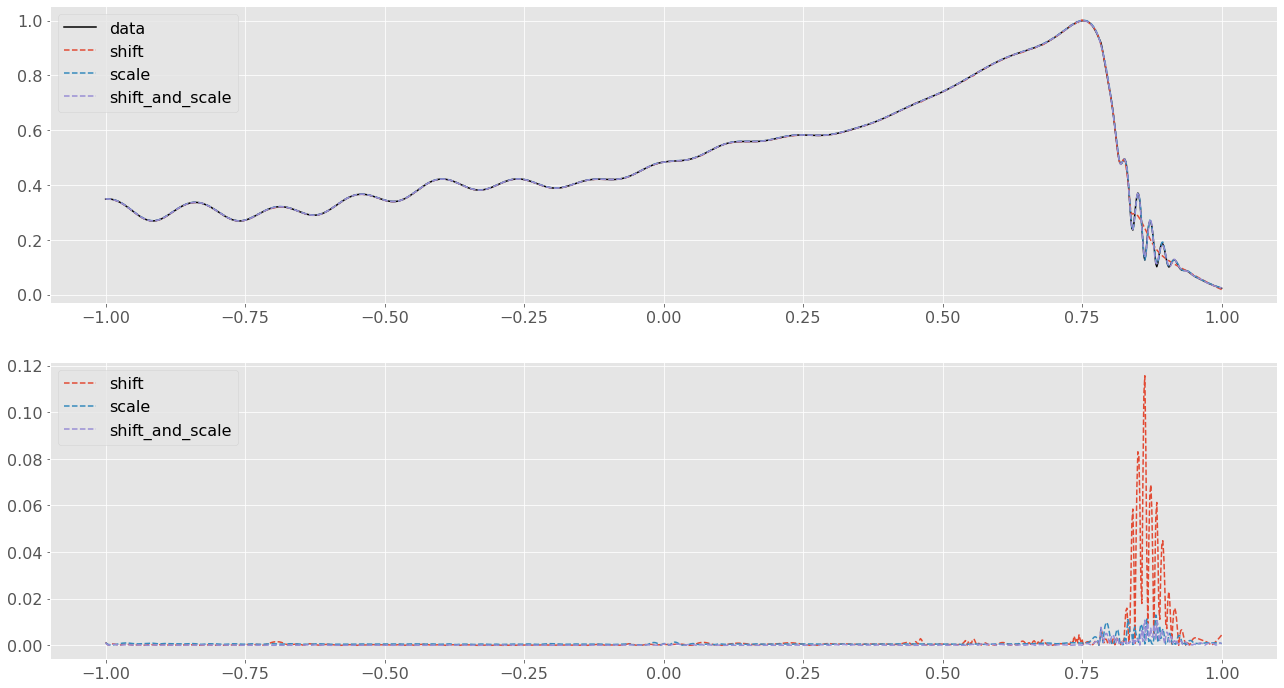

In [150]:
def abs_residual(y, yhat):
    return np.abs(y-yhat)

shift_yhat = shift['model'].predict(common_times_scaled).T
scale_yhat = scale['model'].predict(common_times_scaled).T
shift_and_scale_yhat = shift_and_scale['model'].predict(common_times_scaled).T

plt.figure(figsize=(22, 12))
plt.subplot(2,1,1)
plt.plot(common_times_scaled, amps_prime[0], label='data', c='k')
plt.plot(common_times_scaled, shift_yhat[0], ls='--', label='shift')
plt.plot(common_times_scaled, scale_yhat[0], ls='--', label='scale')
plt.plot(common_times_scaled, shift_and_scale_yhat[0], ls='--', label='shift_and_scale')
# plt.xlim(0.75, 1)
plt.legend()



plt.subplot(2,1,2)
plt.plot(common_times_scaled, abs_residual(amps_prime[0], shift_yhat[0]), ls='--', label='shift')
plt.plot(common_times_scaled, abs_residual(amps_prime[0], scale_yhat[0]), ls='--', label='scale')
plt.plot(common_times_scaled, abs_residual(amps_prime[0], shift_and_scale_yhat[0]), ls='--', label='shift_and_scale')
# plt.xlim(0.75, 1)
plt.legend()
